# AirBnB Case
by David Keller



### Load required libraries

In [1]:
import numpy as np
import pandas as pd
from operator import attrgetter

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

from difflib import SequenceMatcher
import re

import json

import folium
import folium.plugins

#import text2emotion as te
#import textblob
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
%matplotlib inline

tqdm.pandas()

/usr/local/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Load airbnb Data

In [2]:
calendar = pd.read_csv('./data/airbnb_zurich/calendar.csv')
listings = pd.read_csv('./data/airbnb_zurich/listings.csv')
reviews = pd.read_csv('./data/airbnb_zurich/reviews.csv')

## Understand the Business of AirBnB

* What is the market offer in Zürich
   * Where are the best rooms?
   * What kind of appartment is typically for rent?
   * What are the prices?
* How can you optimize your return on AirBnB as a host?
* 

## Market

### Question: What are the best scoring locations?

In [3]:
df_loc = listings[["latitude", "longitude", "review_scores_location"]]

Check if we have longitude and latitude for every listing.

In [4]:
df_loc.longitude.isnull().sum() == 0 and df_loc.latitude.isnull().sum() == 0

True

What percentage of location scores is NaN?

In [5]:
df_loc.review_scores_location.isnull().sum()/df_loc.shape[0]

0.20913978494623656

Roughly one fifth of rows are without a score for the location. We could either drop these before processing or inject a mean value. We follow the second approach here. If a guest does not review the location, we assume he has a neutral opinion here without ups or downs.

In [6]:
df_loc_filled = df_loc.fillna( value=df_loc.review_scores_location.mean(), axis=0 )

Make a plot to get an understanding of the best rated locations.

In [7]:
m = folium.Map(location = [df_loc_filled.latitude.mean(), df_loc_filled.longitude.mean()], tiles='Stamen toner', zoom_start = 12.)
folium.plugins.HeatMap( 
    df_loc_filled, name="Review Score Location", radius=10.,blur=10. ).add_to( m )
m

### What kind of room is for rent?


#### Get an Idea of Room Types in Zürich

AirBnB has different room types in its database. A description is available [here](https://www.airbnb.com/help/article/5/what-does-the-room-type-of-a-listing-mean).
Do we have a room_type for every listing?

In [8]:
listings.room_type.notnull().all()

True

In [9]:
listings.room_type.value_counts()/listings.shape[0]

Entire home/apt    0.676882
Private room       0.310215
Shared room        0.008065
Hotel room         0.004839
Name: room_type, dtype: float64

Two thirds of the listings are entire homes. 31% are private rooms. Shared rooms and hotel rooms are negligible. 

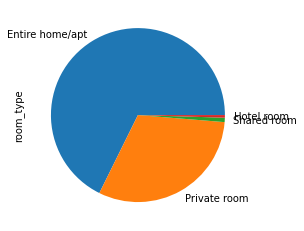

In [10]:
listings.room_type.value_counts().plot.pie()

#### Have a Look at Amenities

The amenities column contains a list of features. Take care, the list is in fact a string.

In [11]:
listings.amenities.head()

0    ["Hot tub", "Heating", "Elevator", "Dryer", "C...
1    ["Fire extinguisher", "Air conditioning", "Ind...
2    ["Stove", "Bed linens", "Elevator", "Microwave...
3    ["Lock on bedroom door", "Heating", "Elevator"...
4    ["Free parking on premises", "Heating", "Eleva...
Name: amenities, dtype: object

We split these into seperate columns for further processing.

In [12]:
def split_amenities( amenities_str ) :
    """
        Transform amenities from a string representation of a list into a pandas.Series which can be used to build new columns
        
        Parameters:
        amenities_list(str): A list of features in string representation
        
        Returns:
        pandas.Series: columns are lowercased entries of input list with blanks replaced by underscore, values are [True/False]
    
    """
    res = dict()
    for key in json.loads( amenities_str ) :
        res[key.lower().replace( " ", "_" )] = 1
    return pd.Series( res, dtype="int" )

In [13]:
amenities = listings.amenities.progress_apply( split_amenities ).fillna( 0 )

100%|██████████| 1860/1860 [00:00<00:00, 2975.48it/s]


In [14]:
amenities.describe()

,hot_tub,heating,elevator,dryer,cable_tv,tv_with_standard_cable,washer,wifi,lake_access,essentials,...,clothing_storage:_walk-in_closet_and_wardrobe,soap_&_showergel_body_soap,"46""_hdtv_with_netflix",miele_electric_stove,la_roche_posay__body_soap,zug_stainless_steel_electric_stove,weleda_body_soap,pantene_shampoo,pool_table,paid_dryer
count,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,...,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000
mean,0.021505,0.850000,0.434946,0.577957,0.286022,0.274731,0.684946,0.930108,0.080645,0.926882,...,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538
std,0.145101,0.357167,0.495883,0.494018,0.452021,0.446499,0.464662,0.255034,0.272363,0.260401,...,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Amenities are not standardized but a manually written information by the hosts. Hence, we have quite some spread and possibly double entries. Have a look at the 30 most popular amenities and their percentage.

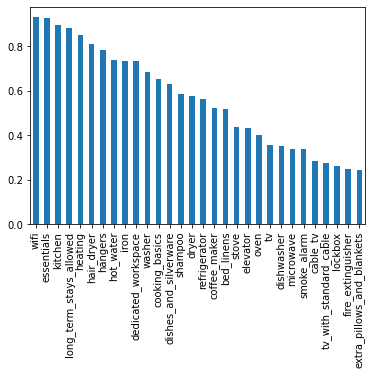

In [15]:
(amenities.sum()/amenities.shape[0]).sort_values( ascending=False ).head(30).plot.bar()

How many columns in amenities have only one single entry?

In [32]:
sparse_columns = amenities.loc[:,amenities.sum()==1].columns
print( sparse_columns )

Index(['gaggenau_oven', 'paid_parking_garage_on_premises_–_20_spaces',
       '55"_hdtv_with_apple_tv,_chromecast,_netflix,_standard_cable',
       'private_outdoor_heated_rooftop_pool', 'fast_wifi_–_248_mbps',
       'gaggenau_electric_stove', '55"_hdtv_with_netflix,_apple_tv',
       'dedicated_workspace:_desk,_table,_office_chair,_and_monitor',
       'nivea__body_soap', 'fast_wifi_–_271_mbps',
       ...
       'clothing_storage:_walk-in_closet_and_wardrobe',
       'soap_&_showergel_body_soap', '46"_hdtv_with_netflix',
       'miele_electric_stove', 'la_roche_posay__body_soap',
       'zug_stainless_steel_electric_stove', 'weleda_body_soap',
       'pantene_shampoo', 'pool_table', 'paid_dryer'],
      dtype='object', length=228)


There are 228 columns with only one entry. They cary valuable information. The description shows that they are quite specific in their formulation and could possibly be summarized in one of the more popular categories.

In order to get some more structure into amenities we make some data cleaning by hand. Build a category dict by hand.

In [88]:
categories = {
    "stove" : re.compile( "stove|oven" ),
    "refigerator" : re.compile( "refigerator" ),
    "soap" : re.compile( "soap" ),
    "wifi" : re.compile( "wifi" ),
    "conditioner" : re.compile( "conditioner" ),
    "sound_system" : re.compile( "sound_system" ),
    "air_conditioning" : re.compile( "air_conditioning" ),
    "patio_or_balcony" : re.compile( "patio_or_balcony" ),
    "free_parking" : re.compile( "free_.*_parking" ),
    "paid_parking" : re.compile( "paid_.*_parking" ),
    "conditioner" : re.compile( "conditioner" ),
    "shampoo" : re.compile( "shampoo" ),
    "clothing_storage" : re.compile( "clothing_storage" ),
    "hair_dryer" : re.compile( "dryer" ),
    "workspace" : re.compile( "workspace" ),
    "children’s_books_and_toys" : re.compile( "children’s_books_and_toys" ),
    "netflix" : re.compile( "netflix" ),
    "hot_tub" : re.compile( "hot_tub|rooftop_pool" ),
    "dedicated_workspace" : re.compile( "dedicated_workspace" ),
    "coffee_maker" : re.compile( "coffee_maker|nespresso_machine" ),
    "smoke_alarm" : re.compile( "smoke_alarm|carbon_monoxide_alarm" ),
    "tv" : re.compile( "^t^.*|.*tv$" )
}

Add the top runners to the categories. Top runners are those columns with more than not null:

In [89]:
def add_top_runner_to_categories( df, category, threshold ) :
    """
        add top runner categories from df to categories
        
        Parameter:
        df(DataFrame) : input dataframe
        category(dict) : dict with column names as keys and re's as values
        threshold(float) : only consider columns with >= threshold not null values
        
        Output:
        dict : new category dict
    """
    new_categories = categories.copy()
    for col in tqdm( amenities.columns ) :
        if ( amenities[col].sum()/amenities.shape[0] >= threshold ) :
            # make sure col is not yet matched by an already existing re
            double = False
            for excol, match in new_categories.items():
                if ( match.search(col) ) :
                    double = True
                    break
            if ( not double ) :
                new_categories[col] = re.compile( col )
    
    return new_categories

In [86]:
re.compile( "soap" ).search( "body_soap" )

<re.Match object; span=(5, 9), match='soap'>

In [90]:
add_top_runner_to_categories( amenities, categories, 0.05 )

100%|██████████| 472/472 [00:00<00:00, 14399.16it/s]


{'stove': re.compile(r'stove|oven', re.UNICODE),
 'refigerator': re.compile(r'refigerator', re.UNICODE),
 'soap': re.compile(r'soap', re.UNICODE),
 'wifi': re.compile(r'wifi', re.UNICODE),
 'conditioner': re.compile(r'conditioner', re.UNICODE),
 'sound_system': re.compile(r'sound_system', re.UNICODE),
 'air_conditioning': re.compile(r'air_conditioning', re.UNICODE),
 'patio_or_balcony': re.compile(r'patio_or_balcony', re.UNICODE),
 'free_parking': re.compile(r'free_.*_parking', re.UNICODE),
 'paid_parking': re.compile(r'paid_.*_parking', re.UNICODE),
 'shampoo': re.compile(r'shampoo', re.UNICODE),
 'clothing_storage': re.compile(r'clothing_storage', re.UNICODE),
 'hair_dryer': re.compile(r'dryer', re.UNICODE),
 'workspace': re.compile(r'workspace', re.UNICODE),
 'children’s_books_and_toys': re.compile(r'children’s_books_and_toys',
 re.UNICODE),
 'netflix': re.compile(r'netflix', re.UNICODE),
 'hot_tub': re.compile(r'hot_tub|rooftop_pool', re.UNICODE),
 'dedicated_workspace': re.compile

In [44]:
amenities.sum().sort_values( ascending=False ).head(60)

wifi                          1730.0
essentials                    1724.0
kitchen                       1668.0
long_term_stays_allowed       1641.0
heating                       1581.0
hair_dryer                    1505.0
hangers                       1458.0
hot_water                     1375.0
iron                          1368.0
dedicated_workspace           1363.0
washer                        1274.0
cooking_basics                1218.0
dishes_and_silverware         1177.0
shampoo                       1092.0
dryer                         1075.0
refrigerator                  1048.0
coffee_maker                   971.0
bed_linens                     962.0
stove                          813.0
elevator                       809.0
oven                           748.0
tv                             665.0
dishwasher                     655.0
microwave                      631.0
smoke_alarm                    626.0
cable_tv                       532.0
tv_with_standard_cable         511.0
l

In [71]:
def collapse_columns( df, categories ) :
    """
        Reduce the number of columns by their name. Sums the values over collapsed columns into new columns.
        
        Parameter:
        df(DataFrame): input data with a numeric dtype
        categories(dict): a dict containing new column names as keys and re's to match on old column names.
        
        Returns:
        DataFrame: resulting df with a reduced number of columns 
        dict: a dictionary with a mapping fomr old column names to new column names
    
    """
    old_to_new = dict()
    df_new = pd.DataFrame()
    
    for cat, match in tqdm(categories.items()) :
        df_new[cat] = np.zeros( df.shape[0] )
        for col in df.columns :
            if ( match.search( col ) ) :
                df_new[cat] += df[col]
                old_to_new[col] = cat
    
    
    return df_new, old_to_new

In [68]:
new_amenities, old_to_new = collapse_columns( amenities, categories )

100%|██████████| 21/21 [00:00<00:00, 231.52it/s]


In [72]:
new_amenities.columns

Index(['stove', 'refigerator', 'soap', 'wifi', 'conditioner', 'sound_system',
       'air_conditioning', 'patio_or_balcony', 'free_parking', 'paid_parking',
       'body_soap', 'shampoo', 'clothing_storage', 'hair_dryer', 'workspace',
       'children’s_books_and_toys', 'netflix', 'hot_tub',
       'dedicated_workspace', 'coffee_maker', 'smoke_alarm'],
      dtype='object')

In [152]:
red_amenities, old_to_new = zip( reduce_columns_by_names_and_threshold( amenities ) )

Eliminating low-runners:   3%|▎         | 54/1860 [00:00<00:03, 534.04it/s]

{'tv_with_standard_cable': 'hdtv_with_standard_cable', 'air_conditioning': 'central_air_conditioning', 'paid_parking_on_premises': 'free_parking_on_premises', 'paid_parking_off_premises': 'paid_street_parking_off_premises', 'private_patio_or_balcony': 'shared_patio_or_balcony', 'dedicated_workspace': 'dedicated_workspace:_monitor,_office_chair,_table,_and_desk', 'refrigerator': 'siemens__refrigerator', 'free_parking_on_premises': 'free_parking_on_premises_–_1_space', 'patio_or_balcony': 'private_patio_or_balcony', 'free_street_parking': 'paid_street_parking_off_premises', 'paid_parking_garage_on_premises_–_20_spaces': 'paid_parking_garage_on_premises_–_10_spaces', 'free_washer_–_in_unit': 'free_washer_–_in_building', '55"_hdtv_with_apple_tv,_chromecast,_netflix,_standard_cable': '70"_hdtv_with_apple_tv,_chromecast,_netflix,_amazon_prime_video,_standard_cable', 'clothing_storage:_closet': 'clothing_storage:_closet_and_wardrobe', 'free_dryer_–_in_unit': 'free_dryer_–_in_building', 'sonos

Eliminating low-runners:  17%|█▋        | 316/1860 [00:00<00:03, 474.65it/s]


In [151]:
def find_common_substring( str1, str2 ) :
    """
        Find a common substring in two strings
        
        Parameters:
        str1: first string
        str2: second string
        
        Returns:
        match-Object
    """
    return SequenceMatcher( None, str1, str2 ).find_longest_match(0, len(str1), 0, len(str2))

def reduce_columns_by_names_and_threshold( df, threshold = 0.01, min_substring_length = 12, categories = [] ) :
    """
        reduce the number of columns in a datafield (like amenities)
        
        Identifies columns with a contribution lower or equal threshold.
        Tries to find matching "parent" columns for these low-runner columns.
        Parents and children share a common portion of their column-name
        If a parent is identified: adds entries of parent and low-runner. Else: drops low-runner.
        
        Parameters:
        df(DataField): a Field containing numeric columns with string column-names
        threshold(Float): a percentage used to identify low-runners [0.0...1.0]
        min_substring_length(Integer): minimum length to consider as a match between column names
        categories(list of string): predefined list of strings for new column names
                                    if not present, the function generates its own new names
        
        Returns:
        Tuple(DataField, Dict): a new DataField generated through collapsing columns 
                                and a Dict describing the mapping from df-column-names to result-column-names
    
    """
    old_to_new_columns = dict()
    df_new = df
    
    
    # create a match matrix
    ##
    match_matrix = np.empty( (df.shape[1], df.shape[1]), dtype="object" )
    column_names = df.columns.to_list()
    for i, c1 in tqdm( enumerate( column_names ), desc="Computing match matrix", leave=True, total=len(column_names) ): 
        for j in range( i+1 ) :
            match_matrix[i,j] = match_matrix[j,i] = find_common_substring( c1, column_names[j] )
            
    # find the best match candidate for every column
    ##
    getsize = np.vectorize( attrgetter( "size" ) )
    match_sizes = getsize( match_matrix )
    np.fill_diagonal( match_sizes, 0 ) # diagonal entries have obviously a full match
    max_match_idx = np.argmax( match_sizes, axis=1 )
    
    for i, col in enumerate(column_names) :
        j = max_match_idx[i]
        if ( match_sizes[i, j] >= min_substring_length ) :
            new_name = column_names[i]
            old_to_new_columns[col] = old_to_new_columns[column_names[j]] = match_matrix[i, j].a
    
    
    print( old_to_new_columns )
    # find low runner columns
    low_runners = df.loc[:,df.sum()/df.shape[0] <= threshold]
    # find high runner column names
    high_runner_cols = [col for col in filter( lambda c : c not in low_runners.columns.to_list(), df.columns )]
    
    # iterate through all low_runners
    for lr in tqdm( low_runners, desc="Eliminating low-runners" ) :
        # compare col with all high_runners
        for hr in high_runner_cols :
            match = find_common_substring( lr, hr )
            # check if we have a match
            if ( match.size > min_substring_length ) :
                # add content of lr to hr column and drop lr column
                df_new[hr] += df_new[lr]
                df_new.drop( [lr], axis=1 )
                old_to_new_columns[lr] = hr
                break
        

    return df_new, old_to_new_columns
    

In [165]:
re.compile( "free_.*_parking" ).search( 'free_street_parking' )

<re.Match object; span=(0, 19), match='free_street_parking'>

In [119]:
amenities.sum()/amenities.shape[0] <= 0.01

hot_tub                               False
heating                               False
elevator                              False
dryer                                 False
cable_tv                              False
                                      ...  
zug_stainless_steel_electric_stove     True
weleda_body_soap                       True
pantene_shampoo                        True
pool_table                             True
paid_dryer                             True
Length: 472, dtype: bool

TODO: Concentrate amenities, reduce number of columns.

In [76]:
test = np.zeros( 3, dtype="object")

In [100]:
tqdm?

Add amenities as new rows to listings and drop original column amenities.

In [14]:
listings_amen = pd.concat( [listings.drop( "amenities", axis=1 ), amenities], axis=1 )

### Understand Data

In [16]:
listings.shape

(1860, 74)

In [17]:
calendar.shape

(678535, 7)

In [18]:
reviews.shape

(50245, 6)

In [19]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,https://www.airbnb.com/rooms/73282,20211228000812,2021-12-28,"Clean, central, quiet",Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,https://www.airbnb.com/rooms/86645,20211228000812,2021-12-28,Stadium Letzigrund - by Airhome,Discover a boutique apartment presented by Air...,Located 300 meters to Zurich Letzigrund Stadio...,https://a0.muscache.com/pictures/miso/Hosting-...,475053,https://www.airbnb.com/users/show/475053,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,https://www.airbnb.com/rooms/143821,20211228000812,2021-12-28,marvelous LOFT in SIHLCITY Zürich,<b>The space</b><br />- 2.5 rooms on 2 floors ...,NaN,https://a0.muscache.com/pictures/1012249/a4f34...,697307,https://www.airbnb.com/users/show/697307,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,https://www.airbnb.com/rooms/178448,20211228000812,2021-12-28,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,https://www.airbnb.com/rooms/204586,20211228000812,2021-12-28,very nice luxury city apartment,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


In [20]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful..."
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...


In [21]:
reviews.describe()

,listing_id,id,reviewer_id
count,5.024500e+04,5.024500e+04,5.024500e+04
mean,1.908273e+07,6.993185e+16,1.042475e+08
std,1.358630e+07,1.651534e+17,1.041389e+08
min,7.328200e+04,3.066130e+05,3.369000e+03
25%,6.293591e+06,2.333291e+08,2.288966e+07
50%,1.790682e+07,4.563381e+08,6.555674e+07
75%,2.750104e+07,6.503771e+08,1.582684e+08
max,5.380350e+07,5.266430e+17,4.366466e+08


### Work on Calendar Dataset

Convert price and adjusted_price column from string to float.

In [22]:
calendar.price = calendar.price.str.replace( "[$,]", "" ).astype(float)
calendar.adjusted_price = calendar.adjusted_price.str.replace( "[$,]", "" ).astype(float)

Convert available column to bool

In [23]:
# check the values in available column
calendar.available.unique()

array(['f', 't'], dtype=object)

In [24]:
calendar["available_boolean"] = (calendar.available == "t")
calendar.drop( "available", axis=1, inplace=True )

AirBnB has a mechanism to adjust prices dynamically. How does this mechanism work in our dataset? Check if price and adjusted_price have any difference:

In [25]:
calendar["price_difference"] = (calendar.price - calendar.adjusted_price)

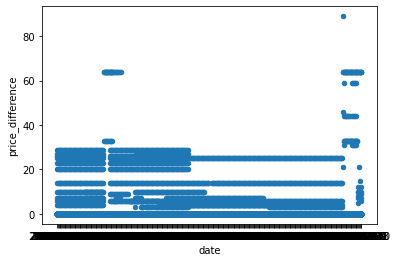

In [26]:
calendar[calendar.available_boolean].plot.scatter( x="date", y="price_difference" )

### Work on the Listings Dataset

In [27]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,https://www.airbnb.com/rooms/73282,20211228000812,2021-12-28,"Clean, central, quiet",Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,https://www.airbnb.com/rooms/86645,20211228000812,2021-12-28,Stadium Letzigrund - by Airhome,Discover a boutique apartment presented by Air...,Located 300 meters to Zurich Letzigrund Stadio...,https://a0.muscache.com/pictures/miso/Hosting-...,475053,https://www.airbnb.com/users/show/475053,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,https://www.airbnb.com/rooms/143821,20211228000812,2021-12-28,marvelous LOFT in SIHLCITY Zürich,<b>The space</b><br />- 2.5 rooms on 2 floors ...,NaN,https://a0.muscache.com/pictures/1012249/a4f34...,697307,https://www.airbnb.com/users/show/697307,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,https://www.airbnb.com/rooms/178448,20211228000812,2021-12-28,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,https://www.airbnb.com/rooms/204586,20211228000812,2021-12-28,very nice luxury city apartment,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


Convert last_scraped to date. And extract the latest date in this column.

In [28]:
listings.last_scraped = pd.to_datetime( listings.last_scraped )
last_scraped_date = listings.last_scraped.max()
print("Last scraped date: %s" % last_scraped_date )

Last scraped date: 2021-12-28 00:00:00


In [29]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Drop columns not relevant for our questions.

In [30]:
listings.drop( ["listing_url", "scrape_id", "last_scraped", "name", "description", "neighborhood_overview", "picture_url", "host_id", "host_url"], axis=1 )

,id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,Simona,2011-02-04,"Zurich, Zurich, Switzerland",I am from Italy and have lived in Zurich for a...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/377532/profil...,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,James,2011-03-31,Wherever you need me. Always happy to help.,Backed by an international team of guest suppo...,within an hour,98%,94%,t,https://a0.muscache.com/im/users/475053/profil...,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,Erhan,2011-06-13,"Zürich, Zurich, Switzerland",Hello everyone!\n\ni am living in Zurich.\n\nh...,within a day,100%,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,Delphine,2011-07-22,"Zurich, Zurich, Switzerland","I am a quiet, friendly and caring person\r\nI ...",NaN,NaN,0%,f,https://a0.muscache.com/im/users/854016/profil...,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,Aicha,2011-08-22,"Zurich, Zurich, Switzerland","I'm a very active person, love traveling, cook...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,53987227,Carena,2016-05-30,"Zürich, Zurich, Switzerland",NaN,within a few hours,100%,67%,f,https://a0.muscache.com/im/pictures/user/9ceeb...,...,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN
1856,53998419,Mia,2018-06-26,"Zürich, Zurich, Switzerland",A happy person that occasionally opens her hom...,within an hour,100%,77%,f,https://a0.muscache.com/im/pictures/user/ee075...,...,NaN,NaN,NaN,NaN,t,8,8,0,0,NaN
1857,54009704,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,NaN,NaN,NaN,NaN,t,7,7,0,0,NaN
1858,54012299,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,NaN,NaN,NaN,NaN,t,7,7,0,0,NaN


### Work on Reviews Dataset

Convert date-column to date-time.

In [31]:
reviews.date = pd.to_datetime( reviews.date )

How many unique reviewers do we have? Percentage of total number of reviews

In [32]:
len(reviews.reviewer_id.unique())/reviews.shape[0]

0.9079908448601851

In [33]:
reviews.groupby( reviews.reviewer_id ).head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful..."
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...
...,...,...,...,...,...,...
50240,53691391,524467838383695057,2021-12-24,4879473,Noel,Wonderful little flat with fantastic views and...
50241,53698682,517237336404489957,2021-12-14,214745755,Karim,perfect
50242,53698682,525191468654428690,2021-12-25,164767134,Jane,"Moro was a wonderful host, the most helpful ev..."
50243,53730106,515756983003727009,2021-12-12,396744268,Julien,Sehr sympathische & gut erschlossene Wohnung. ...


#### Extract Sentiments from Comments

In [34]:
sent = np.vectorize( textblob.TextBlob, reviews.comments.values )

NameError: name 'textblob' is not defined

In [ ]:
sent.sentiment

In [ ]:
pd.DataFrame( sent_pip( reviews.comments.to_list() ) )

In [ ]:
sent_pip?

### Join Datasets

In [ ]:
reviews.join( listings, "", "inner" )

### Playground

In [ ]:
te.get_emotion( reviews.comments.iat[0] )

In [ ]:
for i in range(10) :
        print( te.get_emotion( reviews.comments.iat[i] ))

In [ ]:
reviews.Happy = np.nan
reviews.Angry = np.nan
reviews.Surprise = np.nan
reviews.Sad = np.nan
reviews.Fear = np.nan

In [ ]:
reviews.comments.head(20).progress_apply( compute_emotions )